In [85]:
import cv2

import matplotlib.pyplot as plt
import torch
import numpy as np

def get_interface_line(mask):
    """Get the interface line from the mask (batch)."""
    is_batch = True
    if mask.dim() == 2:
        is_batch = False
        mask = mask.unsqueeze(0)

    B, H, W = mask.shape


    # Get the interface line
    mask = torch.flip(mask, [-2])
    h_coord = torch.argmax(mask, dim=-2, keepdim=True)
    h_coord = H - h_coord - 1
    xx, yy = torch.meshgrid(torch.arange(H, device=mask.device), torch.arange(W, device=mask.device))

    xx = xx.to(mask.device)

    xx = xx.unsqueeze(0).expand(B, H, W)


    interface_line = xx == h_coord
    interface_line[:, :50, :] = False
    interface_line[:, -50:, :] = False
    if not is_batch:
        interface_line = interface_line.squeeze(0)

    return interface_line


def polyfit(interface_line, deg):
    interface_line = interface_line.squeeze().cpu().numpy()

    line_x = np.sum(interface_line, axis=0)

    argwhere = np.argwhere(line_x)
    x1 = np.min(argwhere)
    x2 = np.max(argwhere)


    x = np.arange(x1, x2)

    y = np.argmax(interface_line, axis=0)[x]
    coeffs = np.polyfit(x, y,  deg=deg)
    return coeffs, x1, x2

def interpolate(coeffs, x):
    return np.polyval(coeffs, x)


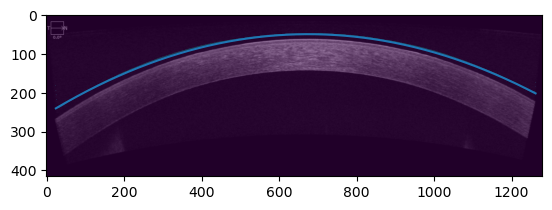

In [88]:
img = cv2.imread('../extern/images/0c8b4a2c284c3cc5ddaf.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('../extern/mask/1cefff8441af97dc046f.mask.png', cv2.IMREAD_GRAYSCALE)


mask = torch.tensor(mask)

interface_line = get_interface_line(mask)

plt.imshow(interface_line)

plt.imshow(img, cmap='gray')

plt.imshow(interface_line, alpha=0.5)


coeffs, x1, x2 = polyfit(interface_line.unsqueeze(0), 5)


x = torch.arange(x1, x2, device=mask.device).float()
y = interpolate(coeffs, x)

plt.plot(x, y)
plt.show()
